# Exercise 3-3

In [1]:
import pysindy as ps
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "font.size": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

In [3]:
np.random.seed(0)

### 3.3.1 Numerical Simulation

In [4]:
def lorenz_dynamics(
    t: float,
    x: ArrayLike,
    sigma: float=10,
    rho: float=28,
    beta: float=8/3,
) -> NDArray:
    """Dynamics of the Lorenz system

    Args:
        x (ArrayLike): N x 3 array of [x, y, z]
        sigma (float, optional): Model parameter. Defaults to 10.
        rho (float, optional): Model parameter. Defaults to 28.
        beta (float, optional): Model parameter. Defaults to 8/3.

    Returns:
        NDArray: Nx3 array of time derivatives of x1 and x2
    """
    xdot = np.empty_like(x)
    xdot[0] = sigma * (x[1] - x[0])
    xdot[1] = x[0] * (rho - x[2]) - x[1]
    xdot[2] = x[0] * x[1] - beta * x[2]
    return xdot

In [5]:
# Compute trajectory
x0 = np.array([0, 1, 20])
dt = 0.01
t = np.arange(0, 6+dt, dt)
solution = solve_ivp(lorenz_dynamics, (t[0], t[-1]), x0, t_eval=t)
x = solution.y.T[int(1/dt):]  # truncate first t=1 of data
t = t[int(1/dt):]

### 3.3.2 Estimate Derivative

In [6]:
def forward_difference(x: ArrayLike, t: ArrayLike=np.arange(len(x))) -> NDArray:
    """Forward difference numerical differentiation

    Args:
        x (ArrayLike): independent variable
        t (ArrayLike, optional): dependent variable. Defaults to np.arange(len(x)).

    Returns:
        NDArray: derivative of independent variable
    """
    dxdt = np.empty_like(x)
    dxdt[:-1] = (x[1:] - x[:-1]) / (t[1:] - t[:-1]).reshape(-1, 1)
    dxdt[-1] = dxdt[-2]
    return dxdt

In [7]:
def central_difference(x: ArrayLike, t: ArrayLike=np.arange(len(x))) -> NDArray:
    """Central difference numerical differentiation

    Args:
        x (ArrayLike): independent variable
        t (ArrayLike, optional): dependent variable. Defaults to np.arange(len(x)).

    Returns:
        NDArray: derivative of independent variable
    """
    dxdt = np.empty_like(x)
    dxdt[1:-1] = (x[2:] - x[:-2]) / (t[2:] - t[:-2]).reshape(-1, 1)
    dxdt[0] = dxdt[1]
    dxdt[-1] = dxdt[-2]
    return dxdt

In [8]:
true_difference = lambda x, t: np.array([lorenz_dynamics(_t, _x) for _t, _x in zip(t, x)])

In [9]:
smooth_difference = ps.differentiation.SmoothedFiniteDifference()

In [10]:
noise_std = 0.001
x_noisy = x + noise_std * np.random.randn(*x.shape)

dxdt_estimates = []
for differentiator in [true_difference, forward_difference, central_difference, smooth_difference]:
    dxdt_estimates.append(differentiator(x_noisy, t))


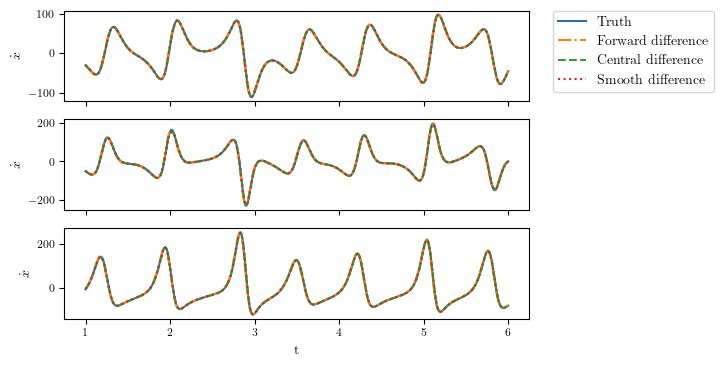

In [11]:
estimator_names = ["Truth", "Forward difference", "Central difference", "Smooth difference"]
linestyles = ["-", "-.", "--", ":"]
fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True)
for i, (dxdt_estimate, label) in enumerate(zip(dxdt_estimates, estimator_names)):
    for j, ax in enumerate(axs):
        ax.plot(t, dxdt_estimate[:, j], linestyles[i], label=label)
_ = [ax.set_ylabel("$\dot{x}$") for ax in axs]
axs[2].set_xlabel("t")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### 3.3.c SINDy from numerical derivatives

In [12]:
feature_library = ps.feature_library.PolynomialLibrary(degree=2)
model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.2), feature_names=["x", "y", "z"])
for dxdt, name in zip(dxdt_estimates, estimator_names):
    model.fit(x=x_noisy, t=t, x_dot=dxdt)
    print(f"gradient method: {name}")
    model.print()
    print("")

    if name == "Truth":
        Phi_mask = model.coefficients().astype(bool)

gradient method: Truth
(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

gradient method: Forward difference
(x)' = -10.145 x + 9.986 y
(y)' = 30.156 x + -2.129 y + -1.037 x z
(z)' = 10.600 1 + -3.110 z + 0.997 x y

gradient method: Central difference
(x)' = -9.985 x + 9.985 y
(y)' = 27.592 x + -0.916 y + -0.987 x z
(z)' = -2.660 z + 0.997 x y

gradient method: Smooth difference
(x)' = -9.971 x + 9.971 y
(y)' = 27.420 x + -0.878 y + -0.983 x z
(z)' = -2.655 z + 0.995 x y



### 3.3.3 SINDy Noise Study

In [13]:
feature_library = ps.feature_library.PolynomialLibrary(degree=2)
model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.2), feature_names=["x", "y", "z"])
differentiators = [true_difference, forward_difference, central_difference, smooth_difference]
noise_stds = np.logspace(-2, 0, 65)
probability_matrix = np.empty((len(noise_stds), len(differentiators)))
for i, noise_std in enumerate(noise_stds):
    for j, (differentiator, name) in enumerate(zip(differentiators, estimator_names)):
        success_mask = []
        for seed in list(range(50)):
            x_noisy = x + noise_std * np.random.randn(*x.shape)
            dxdt = differentiator(x_noisy, t)
            model.fit(x=x_noisy, t=t, x_dot=dxdt)
            if np.all(model.coefficients().astype(bool)== Phi_mask):
                success_mask.append(True)
            else:
                success_mask.append(False)
        probability_matrix[i, j] = sum(success_mask) / len(success_mask)

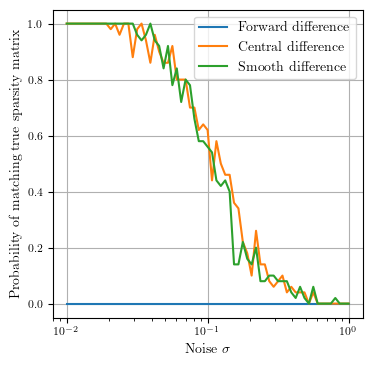

In [15]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.set_xscale("log")
for name, t_end_probabilities in zip(estimator_names[1:], probability_matrix.T[1:]):
    label = f"{name}"
    ax.plot(noise_stds, t_end_probabilities, label=label)
ax.set_xlabel("Noise $\sigma$")
ax.set_ylabel("Probability of matching true sparsity matrix")
ax.legend()
ax.grid(True)
fig.savefig("p3fig1.pdf", bbox_inches="tight")
plt.show()